In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.colors as colors
from scripts.conversion import *
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [9]:
cd ..

/home/rd804/discriminator-metric


In [13]:
# Train XGBoost model
import xgboost as xgb

labels_valid = pd.read_hdf('data/jetnet30_data.h5', 'labels_valid')['labels'].values
labels_train = pd.read_hdf('data/jetnet30_data.h5', 'labels_train')['labels'].values

particle_data_valid = pd.read_hdf('data/jetnet30_data.h5', 'particle_data_valid').values.reshape(-1,30,4)
particle_data_train = pd.read_hdf('data/jetnet30_data.h5', 'particle_data_train').values.reshape(-1,30,4)

# compute mass
m_valid = mjj_jets(particle_data_valid)
m_train = mjj_jets(particle_data_train)

# declare params
params = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 1,
    'nthread': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0.1,
    'lambda': 1,
    'alpha': 0,
    'scale_pos_weight': 1,
    'seed': 42
}

# instantiate classifier
bst = xgb.XGBClassifier(**params)

# train classifier
bst.fit(m_train.reshape(-1,1), labels_train.reshape(-1,1))

# get classifier score on valid data
preds = bst.predict_proba(m_valid)





[13:14:21] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [52]:
# compute roc auc score for preds
auc = roc_auc_score(labels_valid, preds[:,0])
print('AUC: %.3f' % auc)

AUC: 0.507


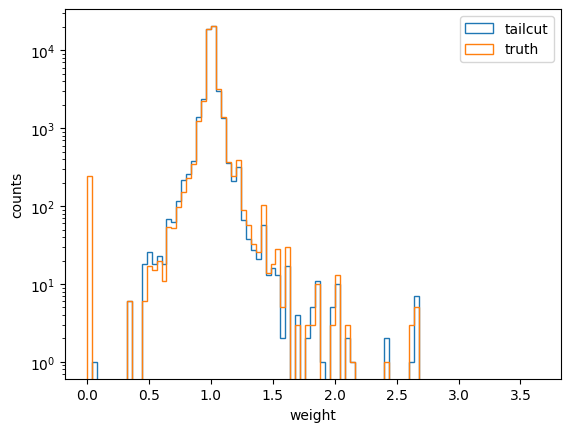

In [64]:
weights = preds[:,0]/(1-preds[:,0])


plt.hist(weights[labels_valid==0], bins=np.arange(min(weights),max(weights),0.04), label='tailcut',histtype='step')
plt.hist(weights[labels_valid==1], bins=np.arange(min(weights),max(weights),0.04), label='truth',histtype='step')
plt.xlabel('weight')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()
plt.show()

In [49]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [28]:
accuracy_score(labels_valid, m_valid>0.17)

0.50245

In [41]:
auc = roc_auc_score(1-labels_valid, ((m_valid<0.17))*1)
print('AUC: %.3f' % auc)

AUC: 0.502


In [58]:
[m_train[labels_train==1]>0.17]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 200000 but corresponding boolean dimension is 100000

In [61]:
truth_train = m_train[labels_train==1]

tail_events = truth_train[truth_train>0.17]

percent = len(tail_events)/len(truth_train)
print(percent*100)

0.47000000000000003


In [68]:
tpr[0:20]*100

array([0.   , 0.002, 0.49 , 0.49 , 0.49 , 0.49 , 0.494, 0.494, 0.494,
       0.494, 0.494, 0.498, 0.498, 0.5  , 0.502, 0.504, 0.504, 0.506,
       0.506, 0.51 ])

In [69]:
fpr[0:20]*100

array([0.   , 0.   , 0.   , 0.002, 0.006, 0.01 , 0.01 , 0.012, 0.016,
       0.02 , 0.024, 0.024, 0.028, 0.028, 0.032, 0.032, 0.036, 0.036,
       0.038, 0.038])

In [70]:
thres[0:20]

array([1.2111876 , 0.21118754, 0.17005295, 0.16998293, 0.16992839,
       0.16983609, 0.16982023, 0.16981609, 0.16980508, 0.16979648,
       0.16979451, 0.16973582, 0.16966908, 0.16964042, 0.16959961,
       0.16957232, 0.16949075, 0.16947128, 0.16946664, 0.16945602],
      dtype=float32)

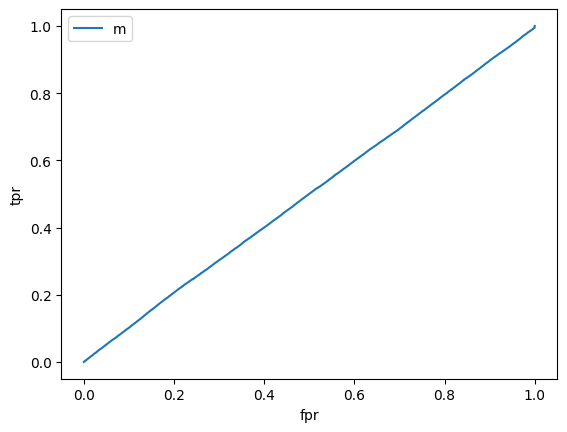

In [66]:
fpr , tpr, thres = roc_curve(labels_valid, m_valid)

plt.plot(1-fpr, 1-tpr, label='m')
#plt.plot([0,1],[0,1], label='random')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.show()


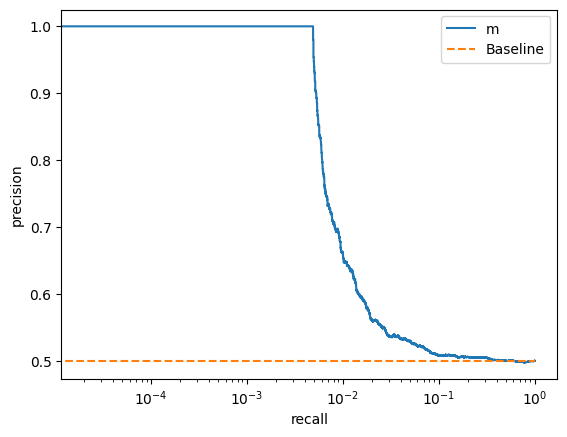

In [78]:
# precision recall curve
precision, recall, thresholds = precision_recall_curve(labels_valid, m_valid)
plt.plot(recall, precision, label='m')
plt.plot([0, 1], [0.5, 0.5], linestyle='--', label='Baseline')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xscale('log')
plt.legend()
plt.show()

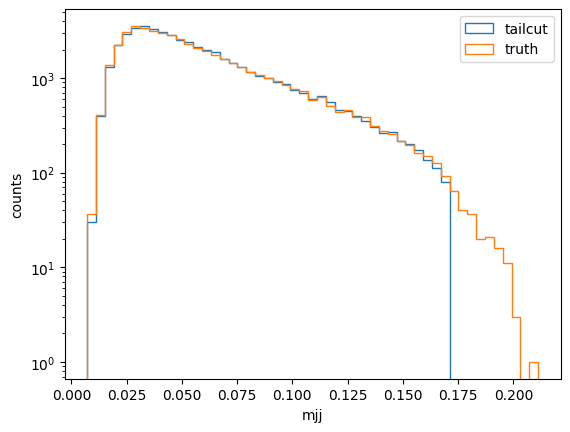

In [69]:
# plot m_valid for different labels
plt.hist(m_valid[labels_valid==0], bins=np.arange(min(m_valid),max(m_valid),0.004), label='tailcut',histtype='step')
plt.hist(m_valid[labels_valid==1], bins=np.arange(min(m_valid),max(m_valid),0.004), label='truth',histtype='step')
plt.xlabel('mjj')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()
plt.show()


In [2]:
tests =[ {'exp_name': 'trial_1_ln_jetnet30',
          'best_epoch': 0,
          'type': 'lorentznet'},
           {'exp_name': 'trial_1_pn_jetnet30',
          'best_epoch': 'best_model_score',
          'type': 'particlenet'},
           {'exp_name': 'trial_1_remove_tail_PN',
          'best_epoch': 'best_model_score',
          'type': 'particlenet'},
           {'exp_name': 'test_cartesian_1',
            'best_epoch': 3,
          'type': 'lorentznet'} ,
          {'exp_name': 'test_3_cartesian_particlenet',
           'best_epoch': 'best_model_score',
           'type': 'particlenet'}]


In [3]:
test_pn_tailcut = [{'exp_name': f'test_{trial+1}_cartesian_particlenet',
           'best_epoch': 'best_model_score',
           'type': 'particlenet'} for trial in range(5)]

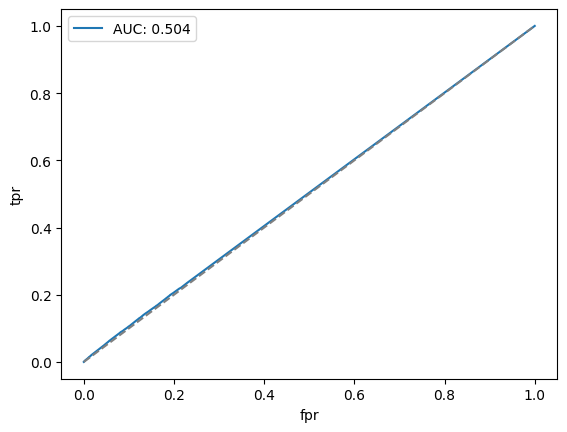

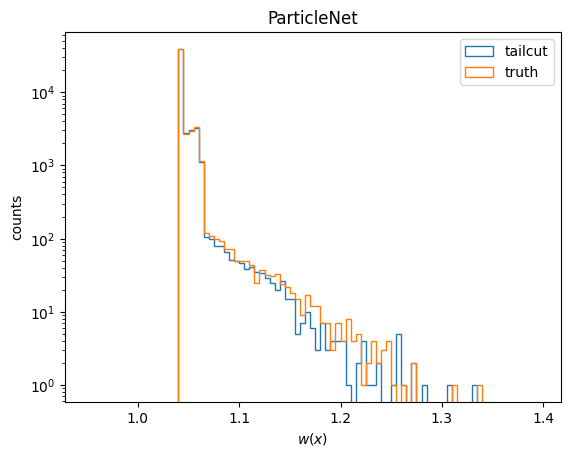

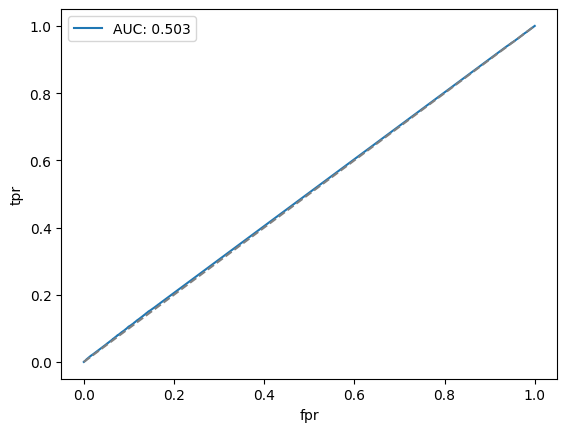

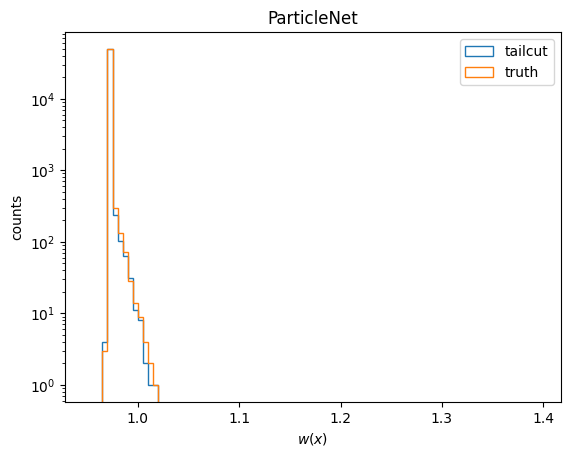

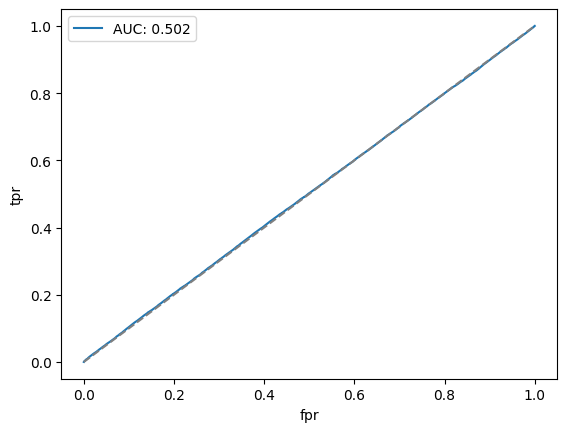

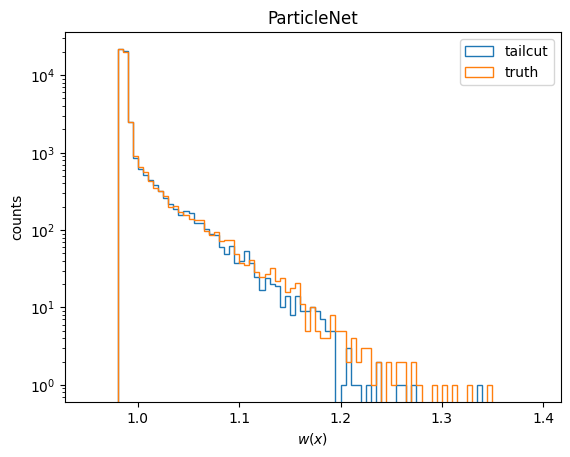

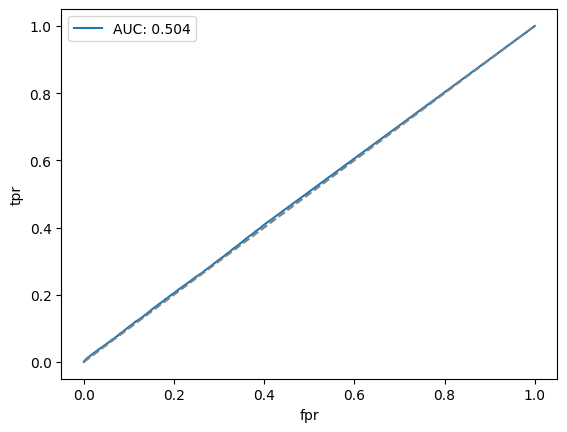

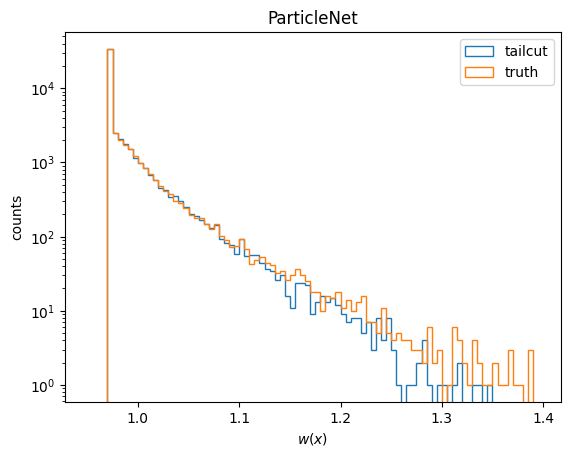

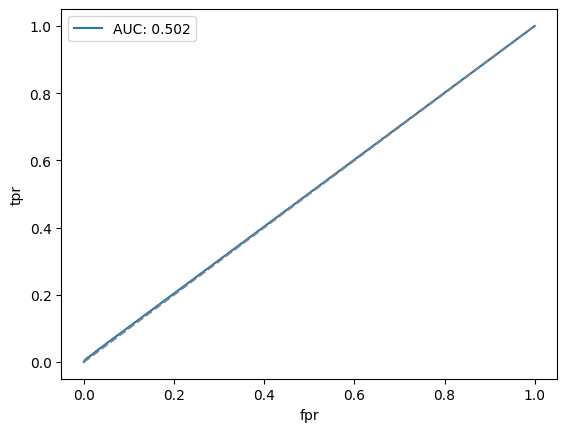

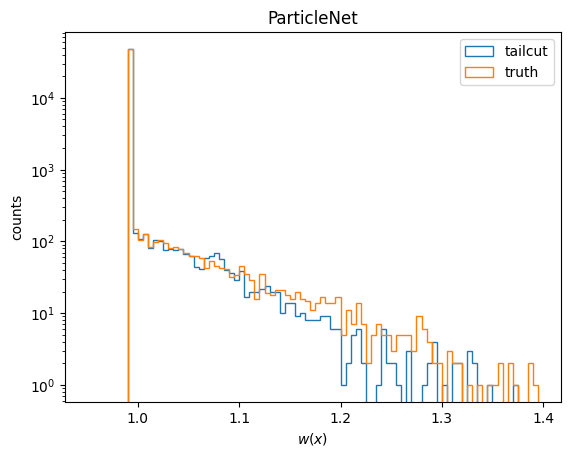

In [87]:
# plot roc curves for different models


labels = pd.read_hdf('data/jetnet30_data.h5', 'labels_valid')['labels'].values


for trials in test_pn_tailcut:
    direc = f'output/{trials["exp_name"]}'
    score = np.load(f'{direc}/{trials["best_epoch"]}.npy')[:,0]
    auc = roc_auc_score(labels, score)
    
  #  score = 1-score

    weights = score/(1-score)
    fpr , tpr, _ = roc_curve(labels, score)
    plt.plot(fpr, tpr, label=f'AUC: {auc:.3f}')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()
    plt.show()

   # weights = 

    plt.hist(weights[labels==0], bins=np.arange(0.95,1.4,0.005), histtype='step', label='tailcut')
    plt.hist(weights[labels==1], bins=np.arange(0.95,1.4,0.005), histtype='step', label='truth')
    plt.yscale('log')
    plt.xlabel(r'$w(x)$')
    plt.ylabel('counts')
    #plt.xscale('log')
    plt.title(f'ParticleNet')
    plt.legend()
    plt.show()       



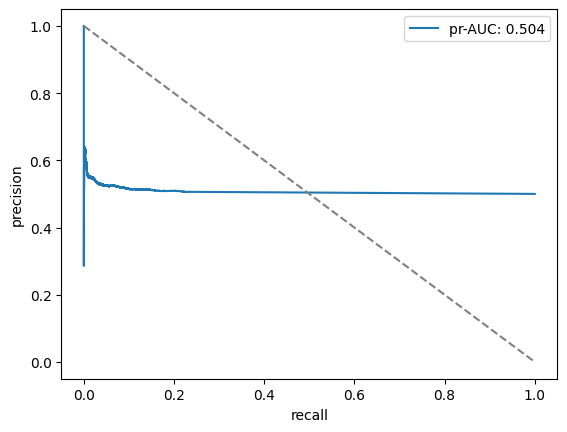

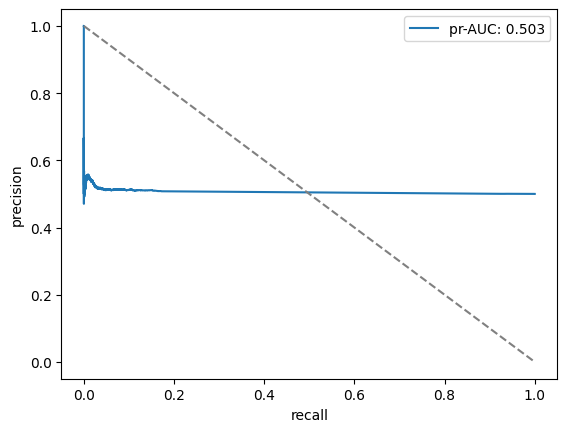

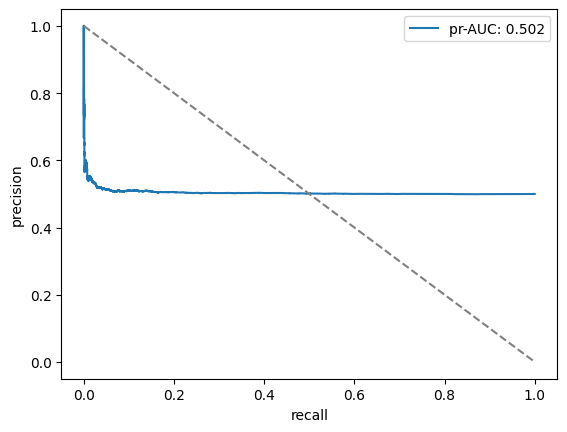

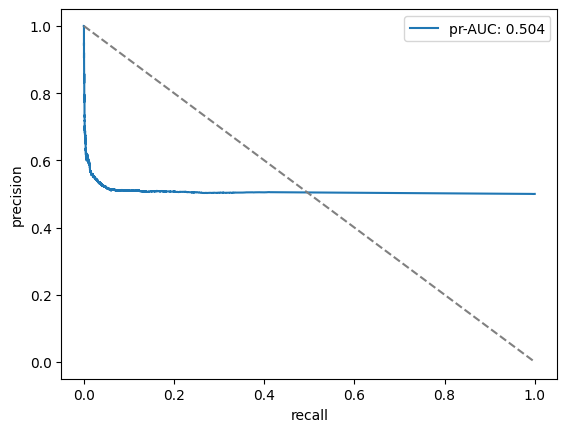

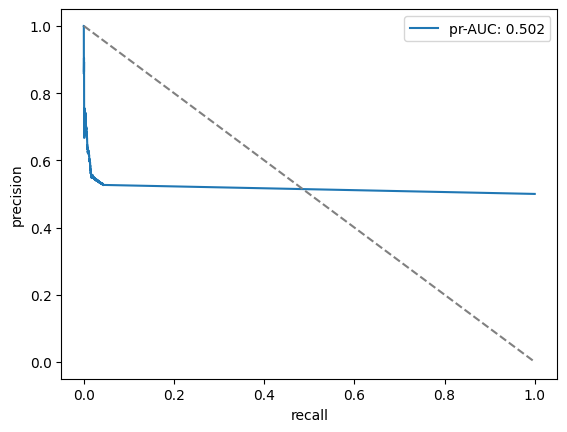

In [102]:
# plot precision recall curves for different models with pr-AUCs

labels = pd.read_hdf('data/jetnet30_data.h5', 'labels_valid')['labels'].values


for trials in test_pn_tailcut:
    direc = f'output/{trials["exp_name"]}'
    score = np.load(f'{direc}/{trials["best_epoch"]}.npy')[:,0]
    auc = roc_auc_score(labels, score)
    
  #  score = 1-score

    weights = score/(1-score)
    precision , recall, _ = precision_recall_curve(labels, score)
    plt.plot(recall, precision, label=f'pr-AUC: {auc:.3f}')
    plt.plot([0,1], [1,0], '--', color='gray')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.show()

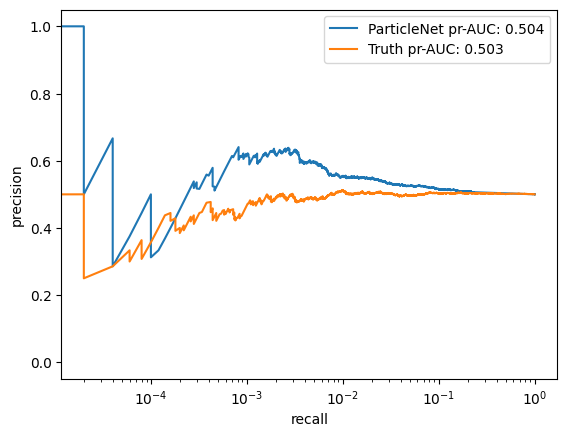

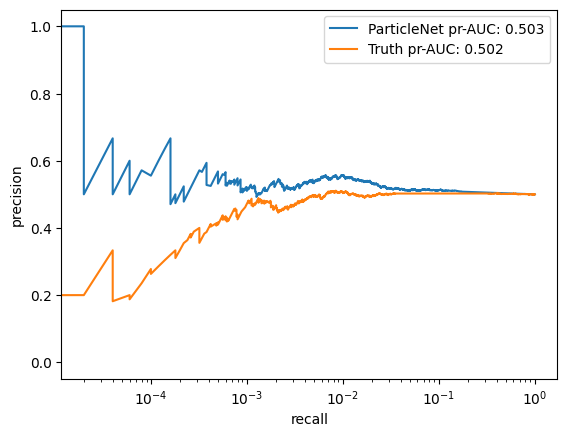

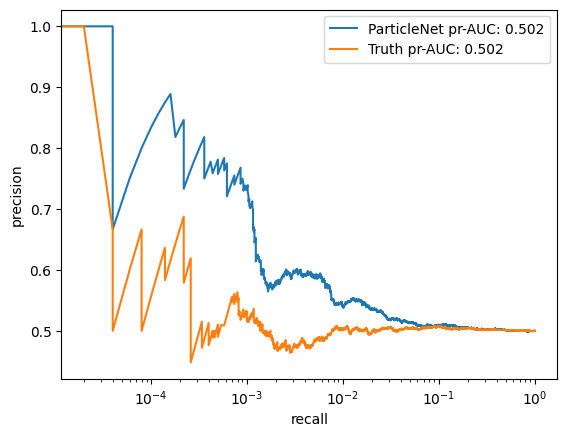

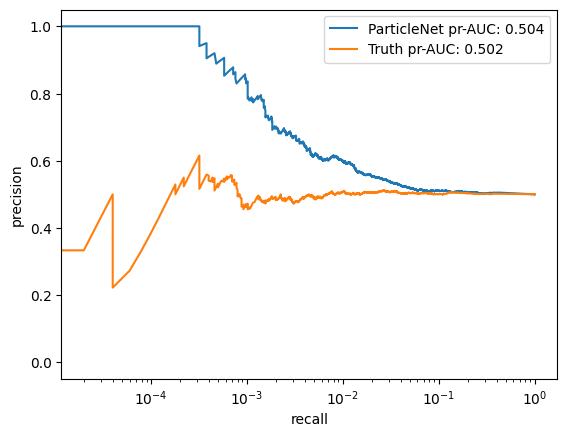

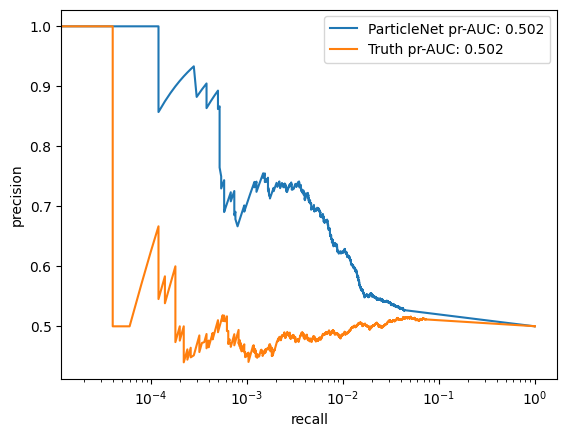

In [89]:
for trials_pn, trails_pf in zip(test_pn_tailcut,tests_truth_pf):
    direc_pn = f'output/{trials_pn["exp_name"]}'
    direc_pf = f'output/{trails_pf["exp_name"]}'
    score_pn = np.load(f'{direc_pn}/best_model_score.npy')[:,0]
    score_pf = np.load(f'{direc_pf}/best_model_score.npy')[:,0]
    auc_pn = roc_auc_score(label, score_pn)
    auc_pf = roc_auc_score(label, score_pf)
    
  #  score = 1-score

    precision_pn , recall_pn, _ = precision_recall_curve(label, score_pn)
    precision_pf , recall_pf, _ = precision_recall_curve(label, score_pf)
    plt.plot(recall_pn, precision_pn, label=f'ParticleNet pr-AUC: {auc_pn:.3f}')
    plt.plot(recall_pf, precision_pf, label=f'Truth pr-AUC: {auc_pf:.3f}')
    #plt.plot([0,1], [1,0], '--', color='gray')
    plt.xlabel('recall')
    plt.xscale('log')
    plt.ylabel('precision')
    plt.legend()
    plt.show()

In [4]:
tests_ln = ['eta_smeared','shifted','smeared','all_smeared','pt_shifted'
         ,'pt_smeared','truth']

jet_test_ln = [
{'exp_name': f'trial_1_ln_{test}',
 'model_score': 'best_model_score'}
 for test  in tests_ln]

In [5]:
tests_pn = ['eta_smeared','shifted','smeared','all_smeared','pt_shifted'
         ,'pt_smeared','truth']

jet_test_pn = [
{'exp_name': f'trial_1_pn_{test}',
 'model_score': 'best_model_score',
 'type': 'particlenet'}
 for test  in tests_pn]


In [6]:
tests_truth_ln = [
{'exp_name': f'trial_{i+1}_ln_truth',
 'model_score': 'best_model_score'}
 for i  in range(5)]

tests_truth_pf = [
{'exp_name': f'trial_{i+1}_pn_truth',
'best_epoch': 'best_model_score',
 'type': 'particlenet'}
    for i  in range(5)]

In [7]:
tests_truth_pf

[{'exp_name': 'trial_1_pn_truth',
  'best_epoch': 'best_model_score',
  'type': 'particlenet'},
 {'exp_name': 'trial_2_pn_truth',
  'best_epoch': 'best_model_score',
  'type': 'particlenet'},
 {'exp_name': 'trial_3_pn_truth',
  'best_epoch': 'best_model_score',
  'type': 'particlenet'},
 {'exp_name': 'trial_4_pn_truth',
  'best_epoch': 'best_model_score',
  'type': 'particlenet'},
 {'exp_name': 'trial_5_pn_truth',
  'best_epoch': 'best_model_score',
  'type': 'particlenet'}]

In [8]:

label = pd.read_hdf('data/jetnet30_data.h5', 'labels_valid')['labels'].values
print(label.shape)



(100000,)


In [81]:
for test in tests:
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,2]
    elif test['type']=='particlenet':
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,1]

    weights = score/(1-score)
    weights = weights/np.sum(weights)
    plt.hist(weights[labels_valid==0], bins=50,histtype='step', label='tailcut')
    plt.hist(weights[labels_valid==1], bins=50,histtype='step', label='truth')
    plt.legend()
    plt.xlabel('weights')
    plt.ylabel('count')
    plt.yscale('log')
    plt.title(test['type'])
    plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 103176 but corresponding boolean dimension is 100000

In [82]:
test_1 = [tests[-2],tests[-1],tests_truth_pf[-1] ]

for test in test_1:
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')
        weights = score[:,2]/(1-score[:,2])
        plt.hist(weights[labels==0], 
                 bins=np.arange(min(weights), max(weights),0.0005),
                 histtype='step', label='tailcut')
        plt.hist(weights[labels==1], 
                 bins=np.arange(min(weights), max(weights),0.0005),
                 histtype='step', label='truth')
      #  print(np.sum(label-score[:-2,0]))

    elif test['type']=='particlenet':
       # continue
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,0]
        weights = score/(1-score)
        plt.hist(weights[labels==0], bins=np.arange(min(weights), max(weights),0.005),
              histtype='step', label='tailcut')
        plt.hist(weights[labels==1], bins=np.arange(min(weights), max(weights),0.005),
                 histtype='step', label='truth')

        



    plt.xlabel('weights')
    plt.ylabel('count')
    plt.yscale('log')
    if test['type']=='lorentznet':
        plt.legend(loc='upper left')
    else:
        plt.legend()
    #plt.xscale('log')
    #plt.xlim(0.,1.4)
    plt.title(test['type'])
    plt.show()

NameError: name 'tests_truth_pf' is not defined

0
100000
1
2
3


/tmp/ipykernel_25541/3698609277.py:28: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr,label='Tailcut',color='C0')
/tmp/ipykernel_25541/3698609277.py:28: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,label='Tailcut',color='C0')
/tmp/ipykernel_25541/3698609277.py:30: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr,color='C0')
/tmp/ipykernel_25541/3698609277.py:30: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,color='C0')
/tmp/ipykernel_25541/3698609277.py:30: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr,color='C0')
/tmp/ipykernel_25541/3698609277.py:30: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,color='C0')


4
5
6
7


/tmp/ipykernel_25541/3698609277.py:30: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr,color='C0')
/tmp/ipykernel_25541/3698609277.py:30: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,color='C0')
/tmp/ipykernel_25541/3698609277.py:30: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr,color='C0')
/tmp/ipykernel_25541/3698609277.py:30: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,color='C0')
/tmp/ipykernel_25541/3698609277.py:33: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr,label='truth',color='C1')
/tmp/ipykernel_25541/3698609277.py:33: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,label='truth',color='C1')
/tmp/ipykernel_25541/3698609277.py:35: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,color = 'C1')


8
9
10


/tmp/ipykernel_25541/3698609277.py:35: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr,color = 'C1')
/tmp/ipykernel_25541/3698609277.py:35: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,color = 'C1')
/tmp/ipykernel_25541/3698609277.py:35: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,color = 'C1')
/tmp/ipykernel_25541/3698609277.py:35: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr,color = 'C1')


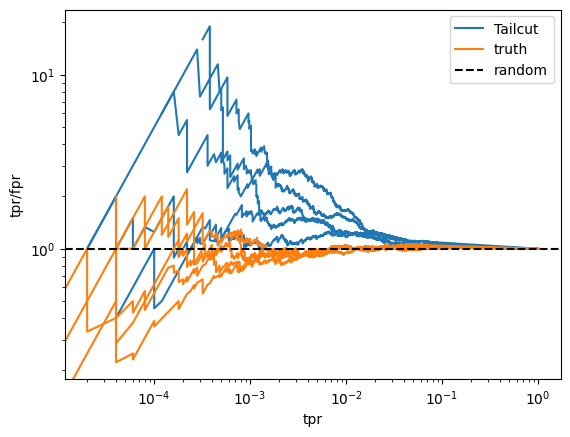

In [131]:
test_1 = [tests[-2],test_pn_tailcut[0],test_pn_tailcut[1],
          test_pn_tailcut[2],test_pn_tailcut[3],
          test_pn_tailcut[4],
          tests_truth_pf[-1],tests_truth_pf[-2],tests_truth_pf[-3]
          ,tests_truth_pf[-4],tests_truth_pf[-5]]


for i,test in enumerate(test_1):
    print(i)
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,2]
        print(len(score))
        #_label = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,0]

        auc = roc_auc_score(label, score)
        fpr, tpr, _ = roc_curve(label, score)
       # plt.plot(tpr, 1/fpr, label=f'{test["type"]} AUC={auc:.3f}')
       # plt.plot(tpr,tpr/fpr)

    elif test['type']=='particlenet':
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,0]
        auc = roc_auc_score(label, score)
        fpr, tpr, _ = roc_curve(label, score)
        if i in [1,2,3,4,5]:
            if i==1:
                plt.plot(tpr,tpr/fpr,label='Tailcut',color='C0')
            else:
                plt.plot(tpr,tpr/fpr,color='C0')
        else:
            if i==6:
                plt.plot(tpr,tpr/fpr,label='truth',color='C1')
            else:
                plt.plot(tpr,tpr/fpr,color = 'C1')

        #plt.plot(tpr, 1/fpr, label=f'{test["type"]} AUC={auc:.3f}')

        

plt.axhline(1,linestyle='--',color='black',label='random')
#plt.plot(tpr,tpr**0.5, label='random',linestyle='--',color='black')
plt.xlabel('tpr')
plt.ylabel('tpr/fpr')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xscale('log')
plt.legend()
#plt.ylim(0.1,10)
#plt.title(test['type'])
plt.show()

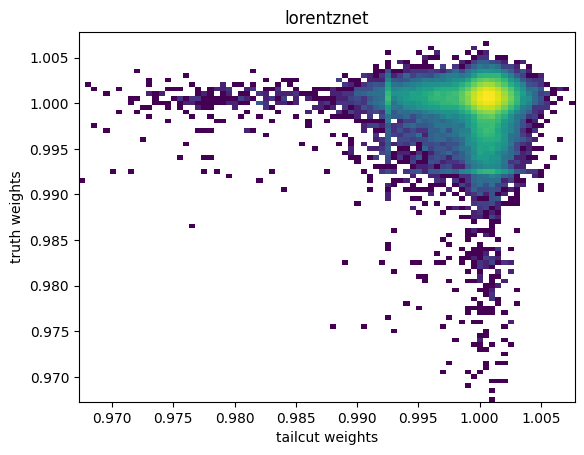

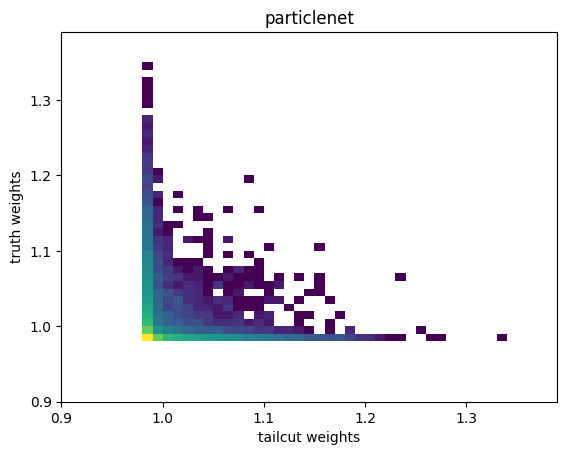

In [141]:
test_1 = [tests[-2],tests[-1]]

for test in test_1:
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')
        weights = score[:,2]/(1-score[:,2])
      #  print(len(weights[label==1]))
      #  print(len(weights[label==0]))
        bins = np.arange(min(weights), max(weights),0.0005)
        plt.hist2d(weights[label==1], weights[label==0],
                 bins=[bins,bins], norm = colors.LogNorm())
        
    elif test['type']=='particlenet':
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,0]
        weights = score/(1-score)
        bins = np.arange(0.9, 1.4,0.01)

        plt.hist2d(weights[label==0],weights[label==1], 
                   bins=[bins,bins], norm = colors.LogNorm())


        



    plt.xlabel('tailcut weights')
    plt.ylabel('truth weights')
    #plt.yscale('log')
    #if test['type']=='lorentznet':
    #    plt.legend(loc='upper left')
   # else:
    #    plt.legend()
    #plt.xscale('log')
    #plt.xlim(0.,1.4)
    plt.title(test['type'])
    plt.show()

(100000, 2)
100000


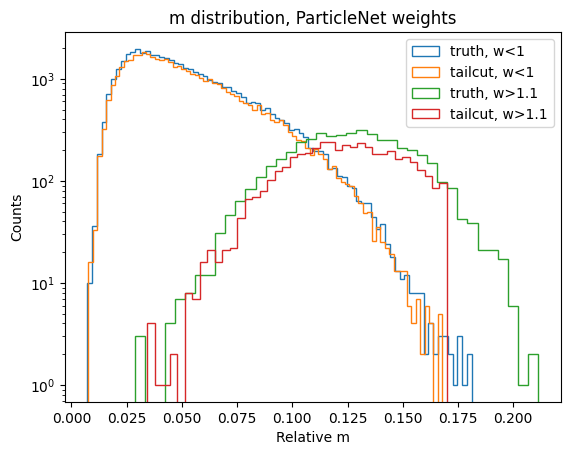

In [89]:
s = 'valid'
test_ = tests[-1]
exp_name = test_['exp_name']
#best_epoch = 3

data = pd.read_hdf('data/jetnet30_data.h5', f'particle_data_{s}').values.reshape(-1,30,4)
labels = pd.read_hdf('data/jetnet30_data.h5', f'labels_{s}')['labels'].values
score = np.load(f'output/{exp_name}/best_model_score.npy')
print(score.shape)
weights = score[:,0]/(1-score[:,0])
print(len(score))

#labels = f[f'labels_{s}']
#pt = pt_jets(data)
m = mjj_jets(data)
#assert len(data) == len(labels)
density = False
figure = plt.figure()
plt.hist(m[(labels==1) & (weights < 1) ], bins=80, 
                histtype='step', label='truth, w<1',density=density)
plt.hist(m[(labels==0) & (weights < 1) ], bins=80, 
                histtype='step', label='tailcut, w<1',density=density)
plt.hist(m[(labels==1) & (weights > 1.) ], bins=40, 
                histtype='step', label='truth, w>1.1',density=density)
plt.hist(m[(labels==0) & (weights > 1.) ], bins=40, 
                histtype='step', label='tailcut, w>1.1',density=density)

#plt.hist(m[(labels==1) & (weights < 0.997) ], bins=100, 
 #               histtype='step', label='label 1, w<0.997',density=True)
#plt.hist(m[labels==1], bins=100, 
 #               histtype='step', label='label 1', density=True)
plt.legend()
plt.xlabel('Relative m')
if density:
    plt.ylabel('Normalized counts')
else:
    plt.ylabel('Counts')
plt.yscale('log')
plt.title(f'm distribution, ParticleNet weights')
plt.show()



In [84]:
accuracy = accuracy_score(label, score[:,0]>0.5)
print(accuracy)

0.50163


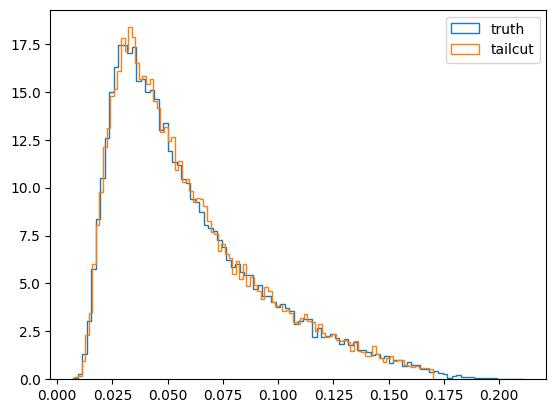

In [89]:
s = 'valid'
data = pd.read_hdf('data/jetnet30_data.h5', f'particle_data_{s}').values.reshape(-1,30,4)
labels = pd.read_hdf('data/jetnet30_data.h5', f'labels_{s}')['labels'].values

m = mjj_jets(data)

plt.hist(m[labels==1], bins=100,histtype='step', label='truth',density=True)
plt.hist(m[labels==0], bins=100, histtype='step', label='tailcut',density=True)
plt.legend()
plt.show()


50000

100000


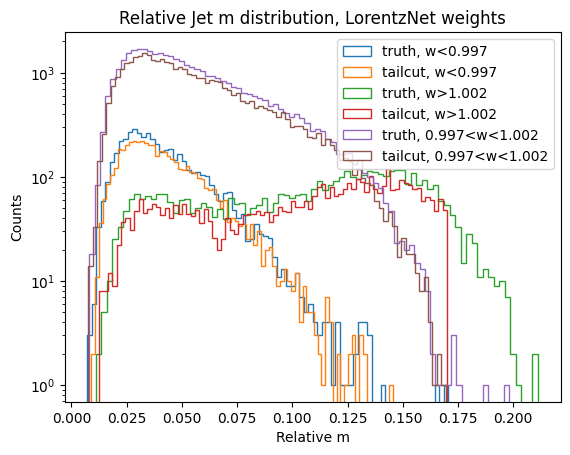

In [72]:
s = 'valid'
exp_name = 'test_cartesian_1'
best_epoch = 3
data = pd.read_hdf('data/jetnet30_data.h5', f'particle_data_{s}').values.reshape(-1,30,4)
labels = pd.read_hdf('data/jetnet30_data.h5', f'labels_{s}')['labels'].values
score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,2]

weights = score/(1-score)
print(len(score))

#labels = f[f'labels_{s}']
#pt = pt_jets(data)
m = mjj_jets(data)
#assert len(data) == len(labels)
density = False
figure = plt.figure()
plt.hist(m[(labels==1) & (weights < 0.997) ], bins=80, 
                histtype='step', label='truth, w<0.997',density=density)
plt.hist(m[(labels==0) & (weights < 0.997) ], bins=80, 
                histtype='step', label='tailcut, w<0.997',density=density)
plt.hist(m[(labels==1) & (weights > 1.002) ], bins=80, 
                histtype='step', label='truth, w>1.002',density=density)
plt.hist(m[(labels==0) & (weights > 1.002) ], bins=80, 
                histtype='step', label='tailcut, w>1.002',density=density)
plt.hist(m[(labels==1) & (weights < 1.002) & (weights > 0.997) ], bins=80, 
                histtype='step', label='truth, 0.997<w<1.002',density=density)

plt.hist(m[(labels==0) & (weights < 1.002) & (weights > 0.997) ], bins=80, 
                histtype='step', label='tailcut, 0.997<w<1.002',density=density)


#plt.hist(m[(labels==1) & (weights < 0.997) ], bins=100, 
 #               histtype='step', label='label 1, w<0.997',density=True)
#plt.hist(m[labels==1], bins=100, 
 #               histtype='step', label='label 1', density=True)
plt.legend()
plt.xlabel('Relative m')
if density:
    plt.ylabel('Normalized counts')
else:
    plt.ylabel('Counts')
plt.yscale('log')
plt.title(f'Relative Jet m distribution, LorentzNet weights')
plt.show()



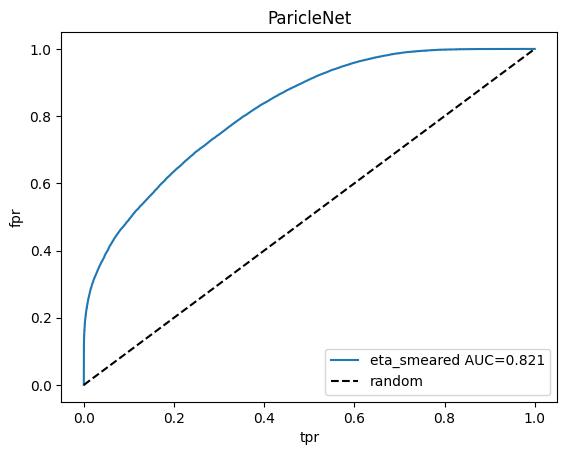

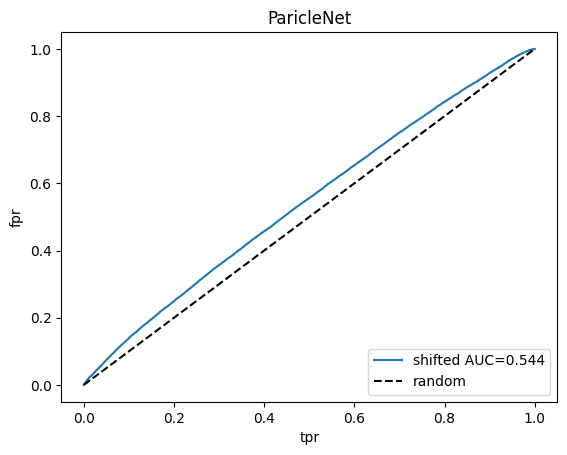

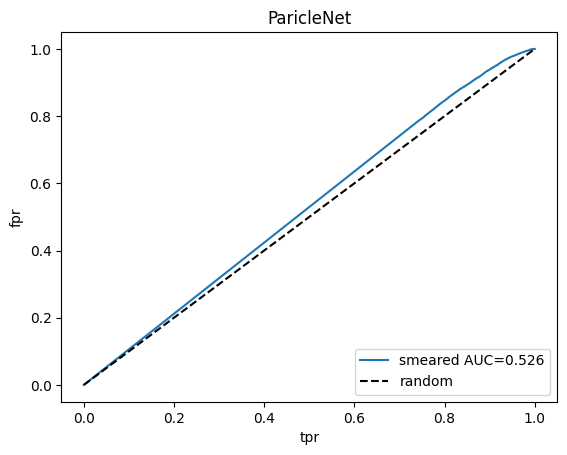

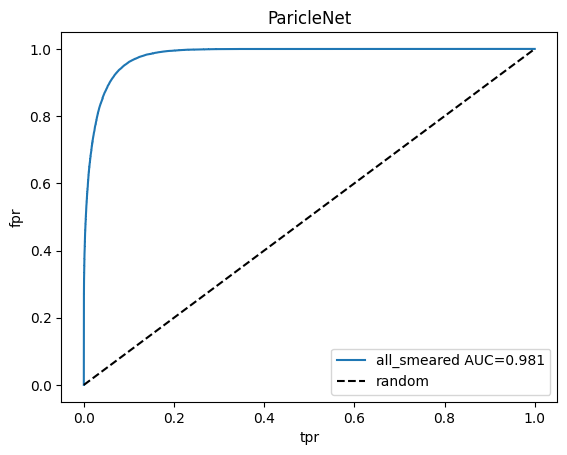

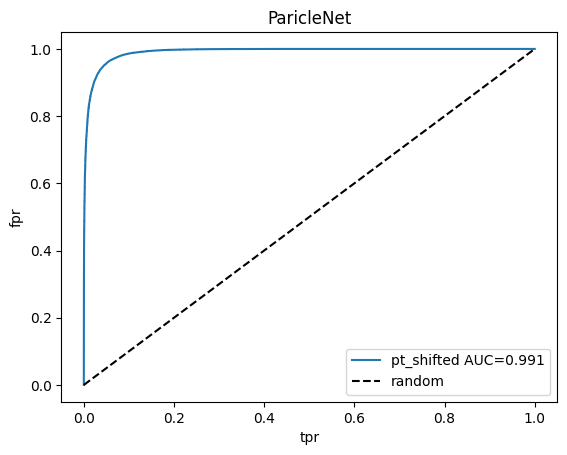

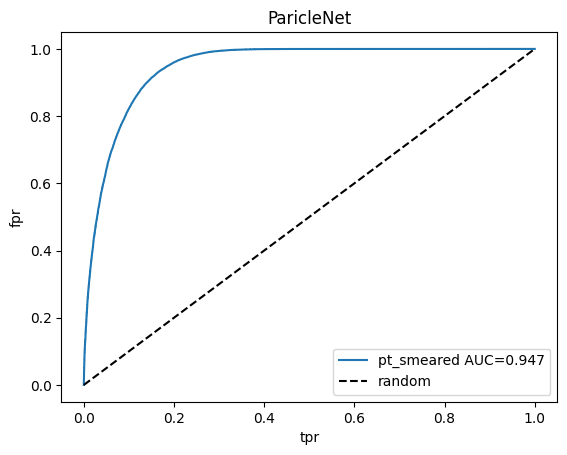

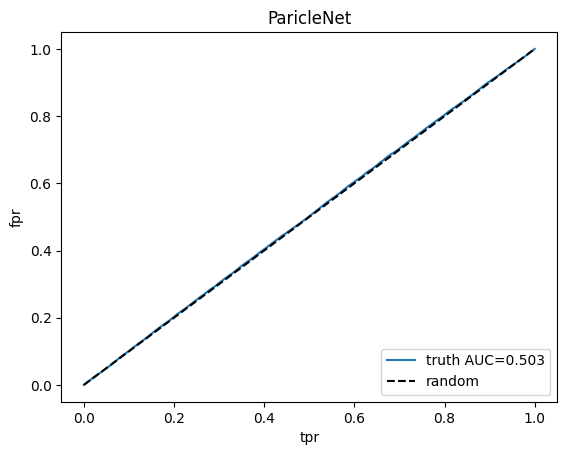

In [92]:
# plot roc curves
s = 'valid'

for i,test in enumerate(tests_pn):
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    exp_name = jet_test_pn [i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')
    assert len(score) == len(label)
    auc = roc_auc_score(label, score[:,0])
    tpr, fpr, _ = roc_curve(label, score[:,0])
    plt.plot(tpr, fpr, label=f'{test} AUC={auc:.3f}')
   # if i==1:
    plt.plot(tpr,tpr, label='random',linestyle='--',color='black')
    plt.xlabel('tpr')
    plt.ylabel('fpr')
    plt.title('ParicleNet')
    #plt.yscale('log')
    plt.legend(loc='lower right')
    plt.show()

In [79]:
truth_exp = jet_test_pn[-1]


{'exp_name': 'trial_1_pn_truth', 'model_score': 'best_model_score', 'type': 'particlenet'}


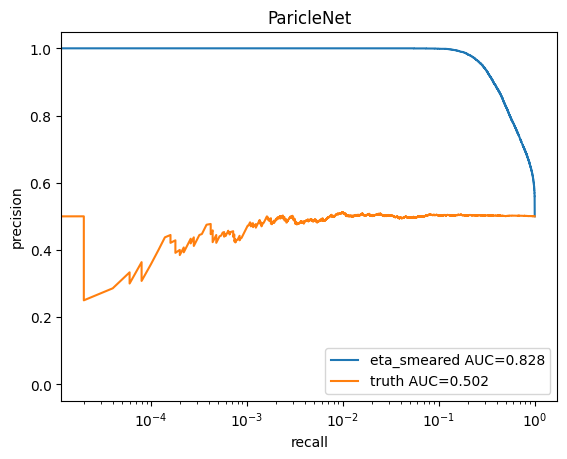

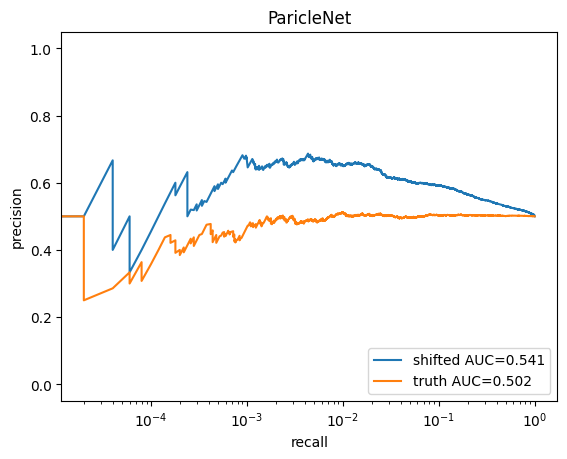

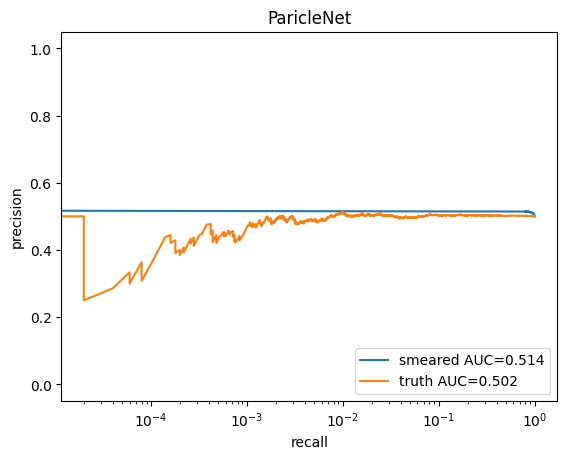

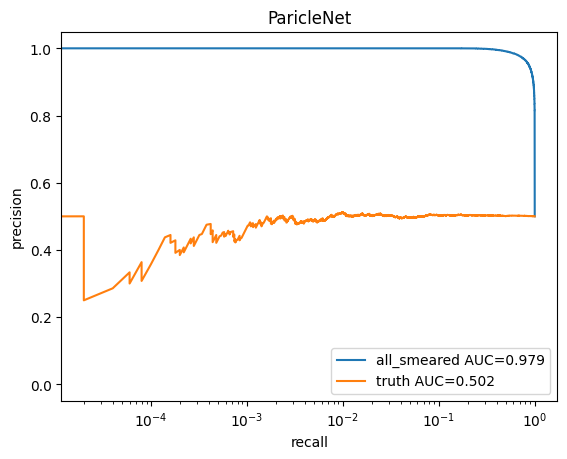

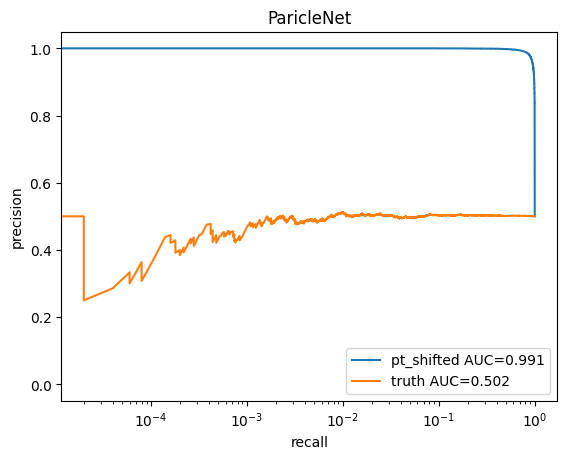

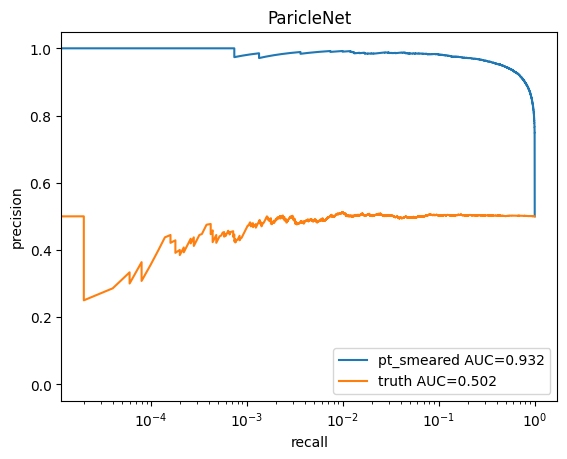

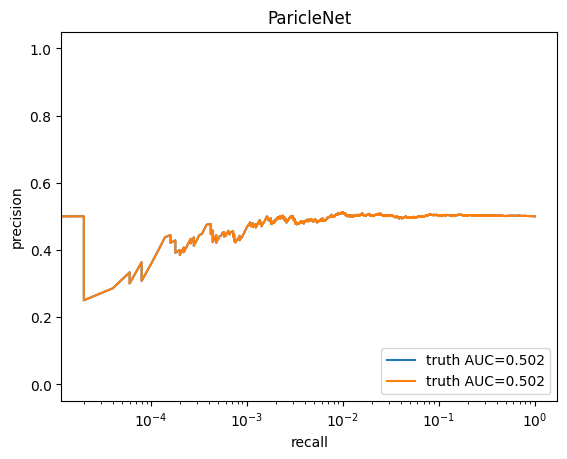

In [82]:
# plot precision recall curves with pr-auc scores
s = 'valid'


for i,test in enumerate(tests_pn):
    # test jet precision recall
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    exp_name = jet_test_pn [i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')
    assert len(score) == len(label)
    auc_test = average_precision_score(label, score[:,0])
    precision, recall, _ = precision_recall_curve(label, score[:,0])


    # truth jet precision recall
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__truth_{s}')['labels'].values
    exp_name = truth_exp['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')
    assert len(score) == len(label)
    auc_truth = average_precision_score(label, score[:,0])
    precision_truth, recall_truth, _ = precision_recall_curve(label, score[:,0])



    plt.plot(recall, precision, label=f'{test} AUC={auc_test:.3f}')
    plt.plot(recall_truth, precision_truth, label=f'truth AUC={auc_truth:.3f}')
   # if i==1:
   # plt.plot(recall,recall, label='random',linestyle='--',color='black')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('ParicleNet')
    plt.xscale('log')
    #plt.yscale('log')
    plt.legend(loc='lower right')
    plt.show()


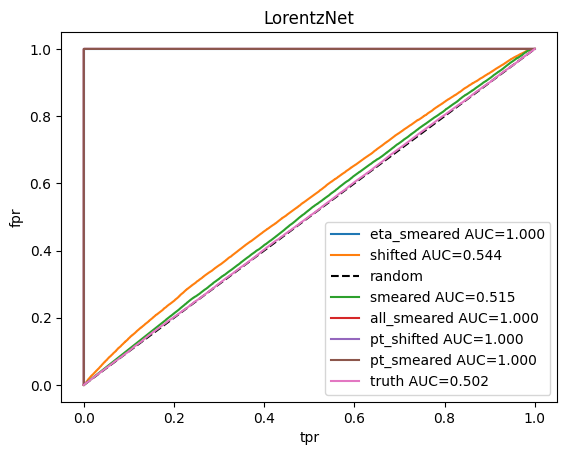

In [7]:
s = 'valid'

for i,test in enumerate(tests_ln):
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    exp_name = jet_test_ln [i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')
    assert len(score) == len(label)
    #print(score.shape)
    auc = roc_auc_score(label, score)
    tpr, fpr, _ = roc_curve(label, score)
    plt.plot(tpr, fpr, label=f'{test} AUC={auc:.3f}')
    if i==1:
        plt.plot(tpr,tpr, label='random',linestyle='--',color='black')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('LorentzNet')
#plt.yscale('log')
plt.legend(loc='lower right')
plt.show()
    #print(f'{auc} for distortion {test}, for LorentzNet')

/tmp/ipykernel_377062/3316082825.py:19: RuntimeWarning: divide by zero encountered in divide
  weights_ = score[:,0]/(1-score[:,0])


7.788446e-14


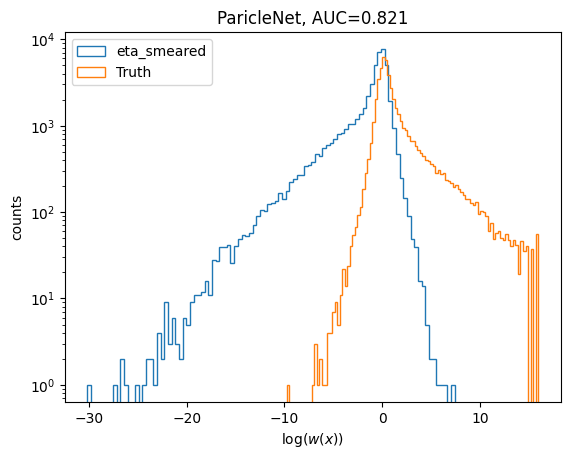

0.12000557


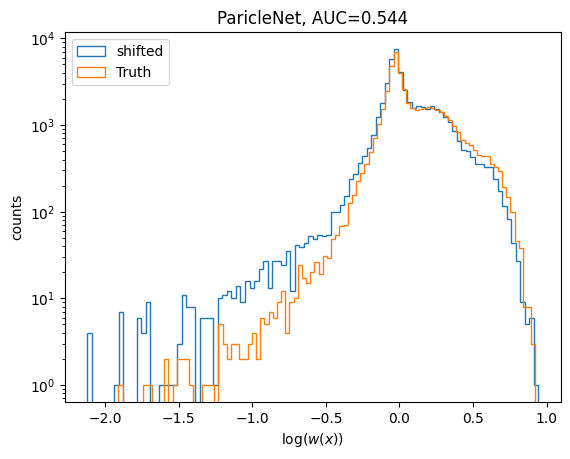

0.01690613


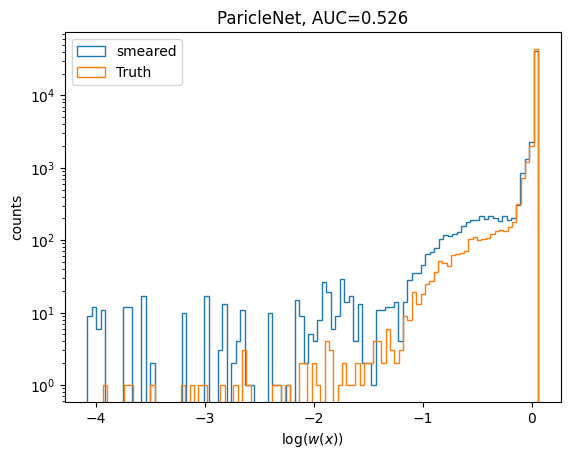

/tmp/ipykernel_377062/3316082825.py:19: RuntimeWarning: divide by zero encountered in divide
  weights_ = score[:,0]/(1-score[:,0])


2.886905e-29


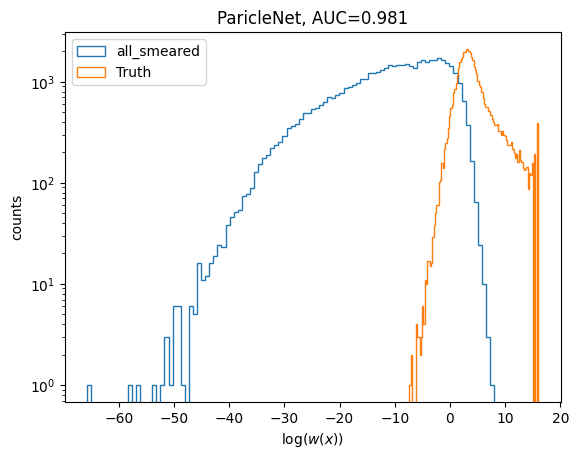

1.2961672e-36


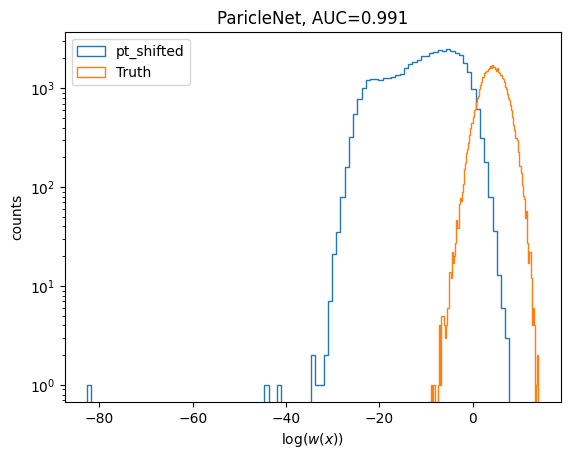

1.187597e-38


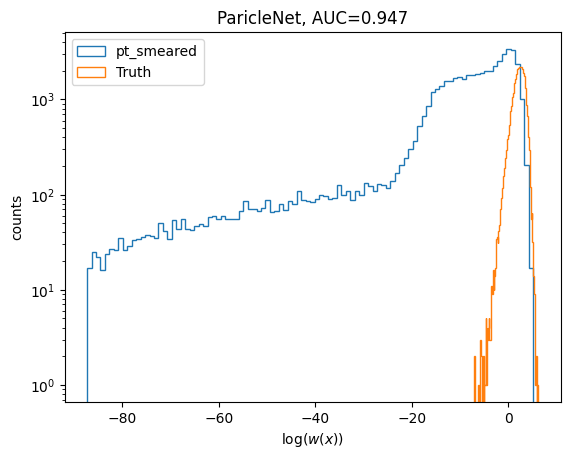

0.99842477


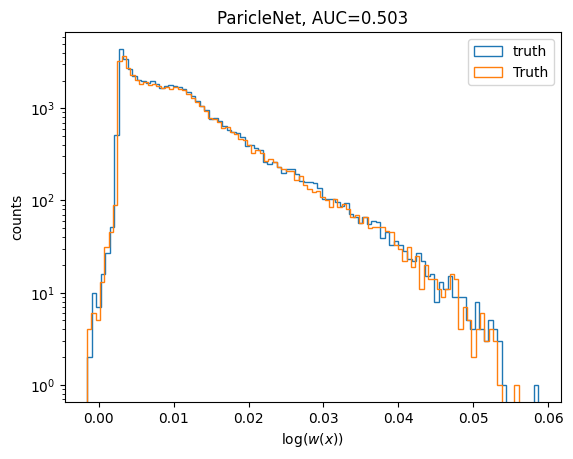

In [97]:
s = 'valid'
for i,test in enumerate(tests_pn):
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    exp_name = jet_test_pn[i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')

   # plt.hist(score[:,0][label==0], label=f'{test}',bins=100, histtype='step')
   # plt.hist(score[:,0][label==1], label='Truth',bins=100, histtype='step')
   # plt.xlabel('score')
   # plt.ylabel('counts')
   # plt.title(f'ParticleNet')
   # plt.yscale('log')
   # plt.legend()
   # plt.show()



  #  print(np.sum((np.argwhere(1-score[:,0])==0)*1))
    weights_ = score[:,0]/(1-score[:,0])
    auc = roc_auc_score(label, score[:,0])

    assert len(score) == len(label)
    label = label[weights_ != np.inf]
    weights_ = weights_[weights_ != np.inf]
    label=label[weights_!=0]
    weights_=weights_[weights_!=0]
    print(np.amin(weights_))
    weights = np.log(weights_+10**(-80))
    #weights[mask] = np.random.randn(len(mask))
   # tpr, fpr, _ = roc_curve(label, score[:,0])
    plt.hist(weights[label==0], label=f'{test}',bins=100, histtype='step')
    plt.hist(weights[label==1], label='Truth',bins=100, histtype='step')

    plt.xlabel(r'$\log (w(x))$')
    plt.ylabel('counts')
    plt.title(f'ParicleNet, AUC={auc:.3f}')
    plt.yscale('log')
    #plt.xscale('log')
    if test == 'truth':
        plt.legend(loc='upper right')
    else:
        plt.legend(loc='upper left')
    plt.show()

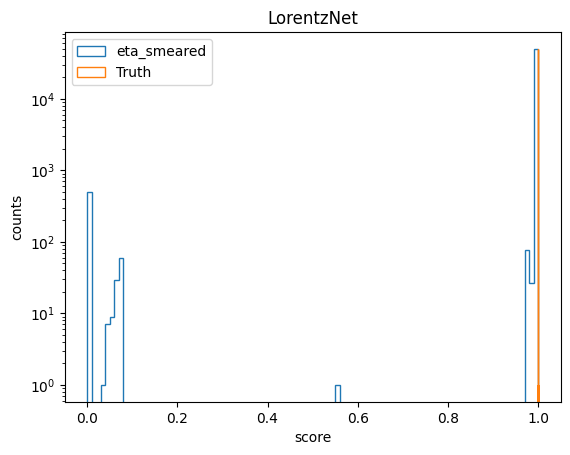

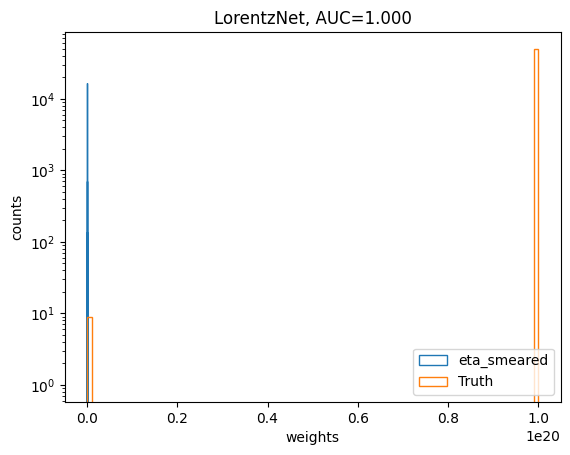

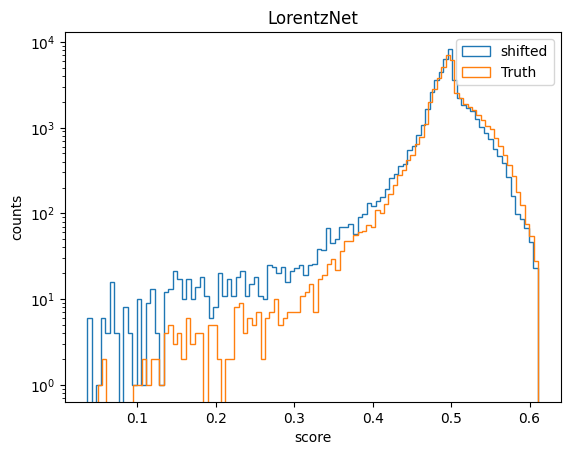

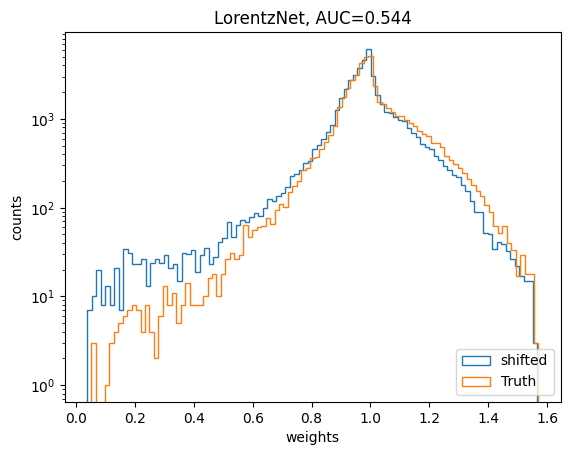

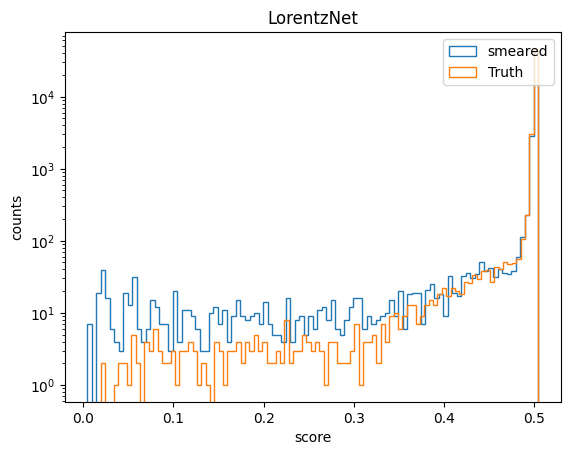

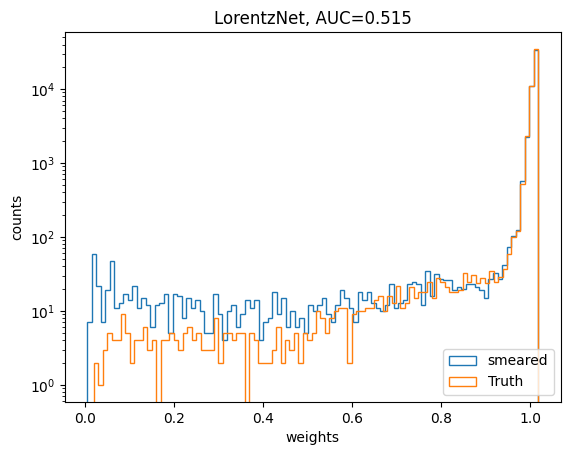

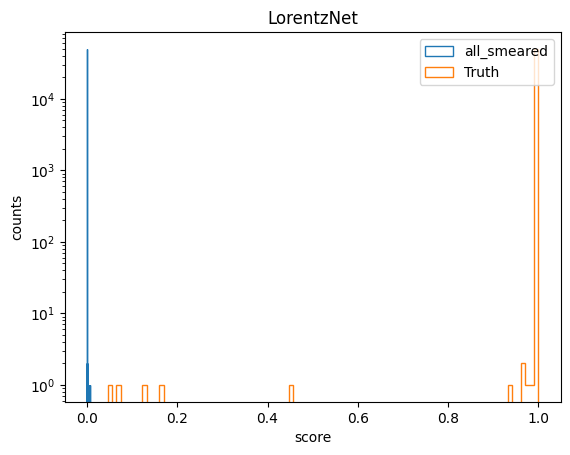

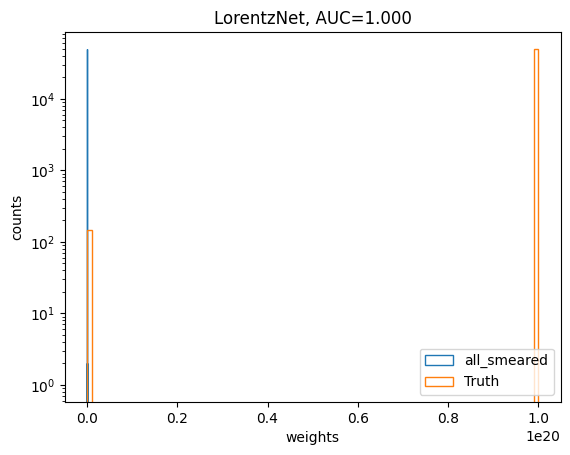

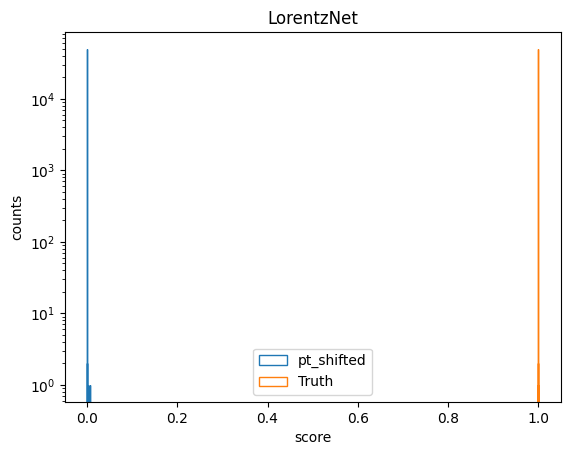

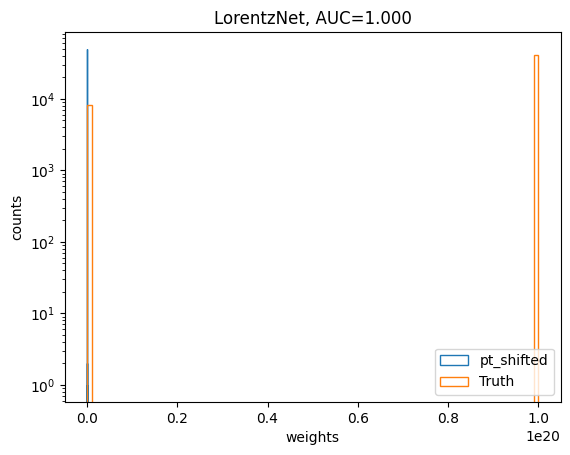

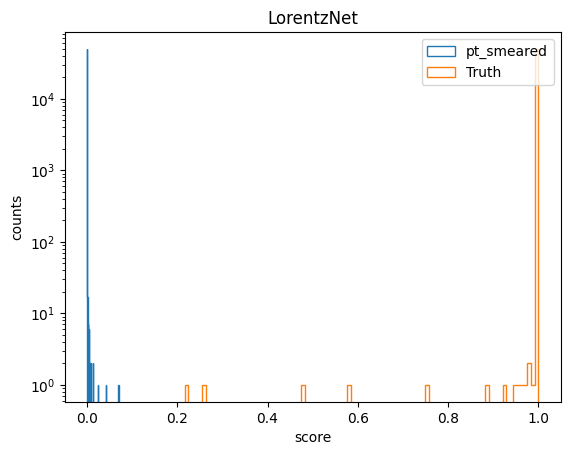

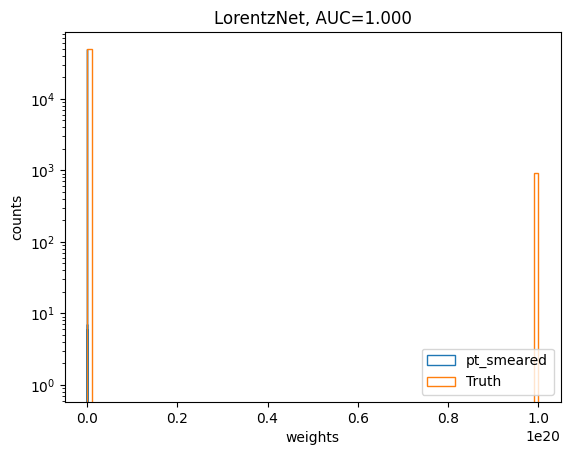

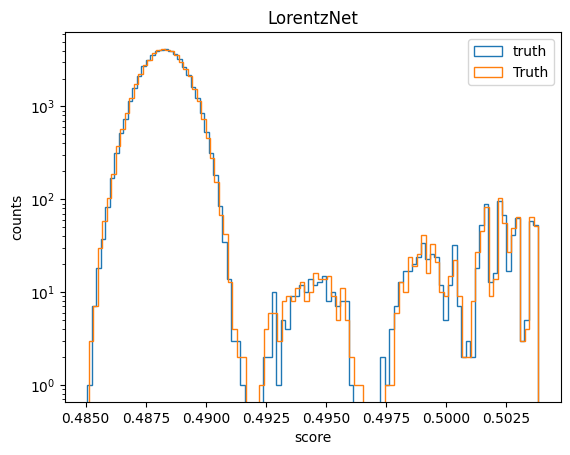

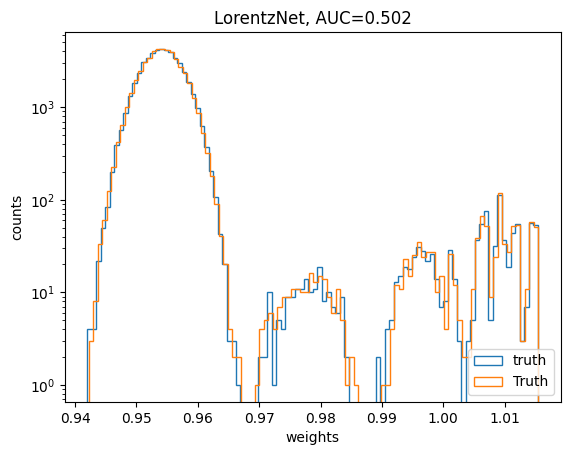

In [43]:
s = 'valid'
for i,test in enumerate(tests_ln):
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values

    
    exp_name = jet_test_ln[i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')

    plt.hist(score[label==0], label=f'{test}',bins=100, histtype='step')
    plt.hist(score[label==1], label='Truth',bins=100, histtype='step')
    plt.xlabel('score')
    plt.ylabel('counts')
    plt.title(f'LorentzNet')
    plt.yscale('log')
    plt.legend()
    plt.show()
    weights = score/(1-score+1e-20)
    assert len(score) == len(label)
    auc = roc_auc_score(label, score)
   # tpr, fpr, _ = roc_curve(label, score[:,0])
    plt.hist(weights[label==0], label=f'{test}',bins=100, histtype='step')
    plt.hist(weights[label==1], label='Truth',bins=100, histtype='step')

    plt.xlabel('weights')
    plt.ylabel('counts')
    plt.title(f'LorentzNet, AUC={auc:.3f}')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.show()

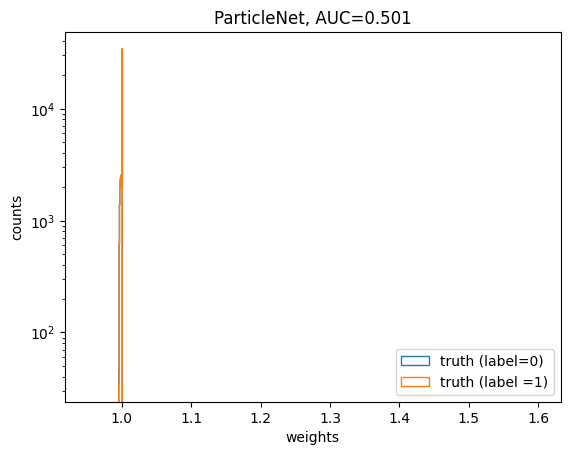

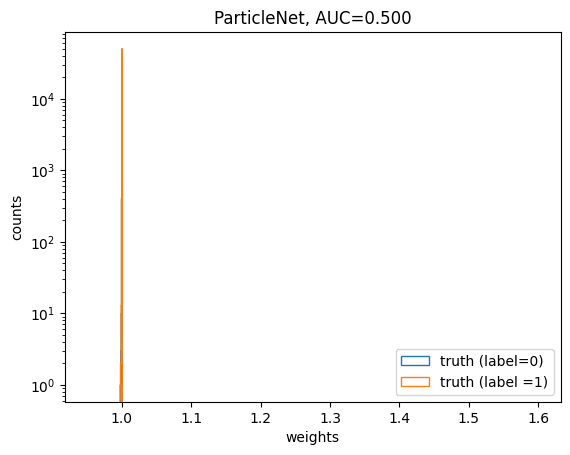

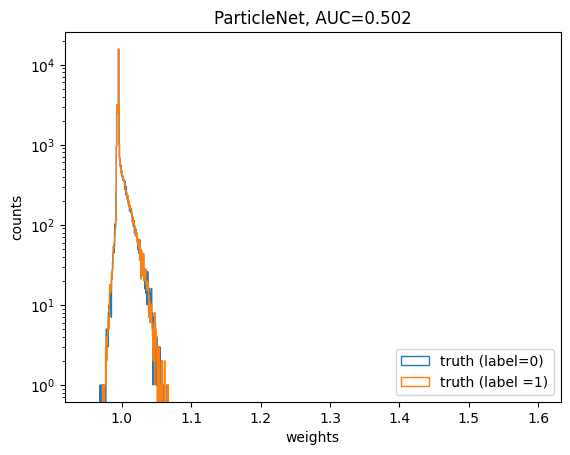

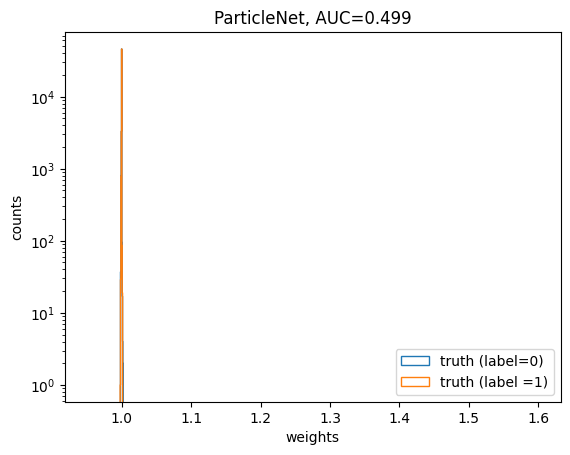

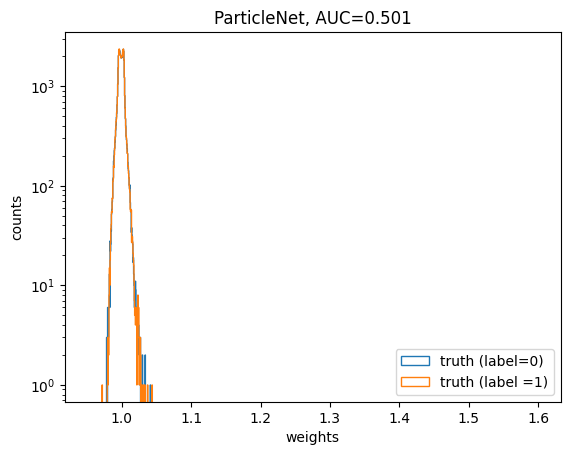

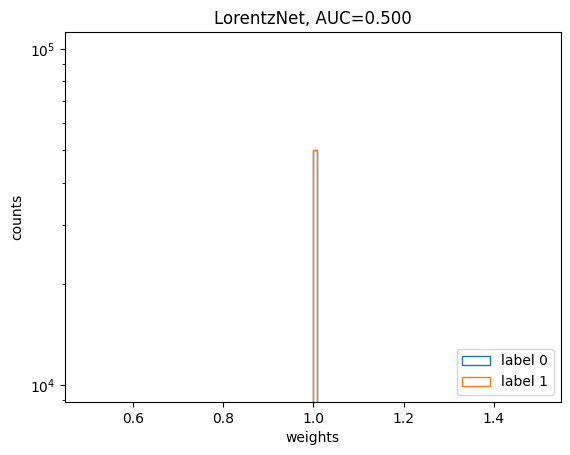

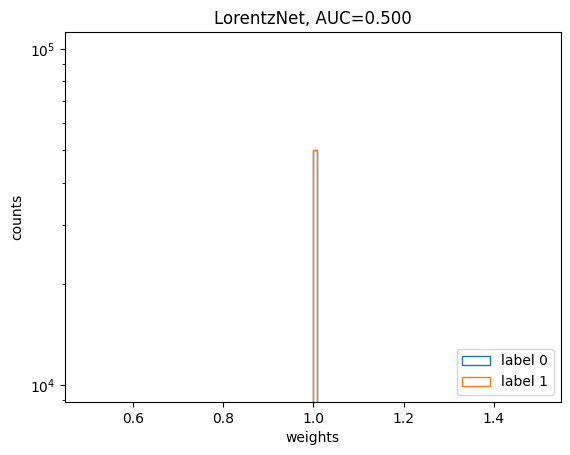

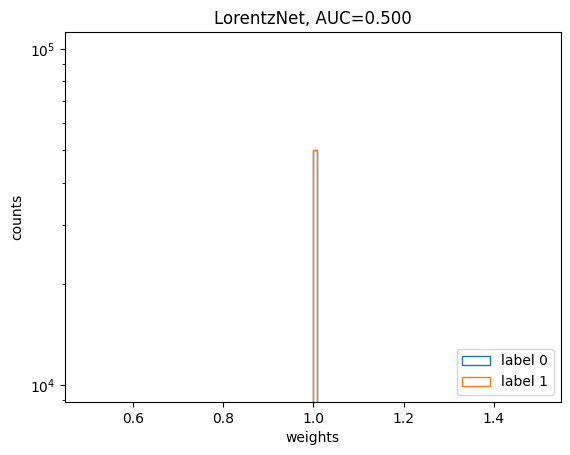

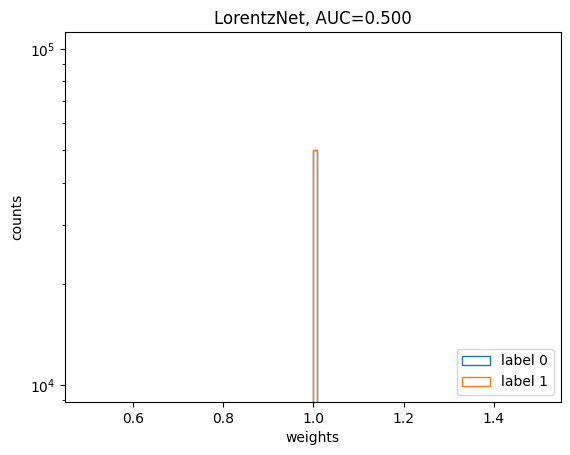

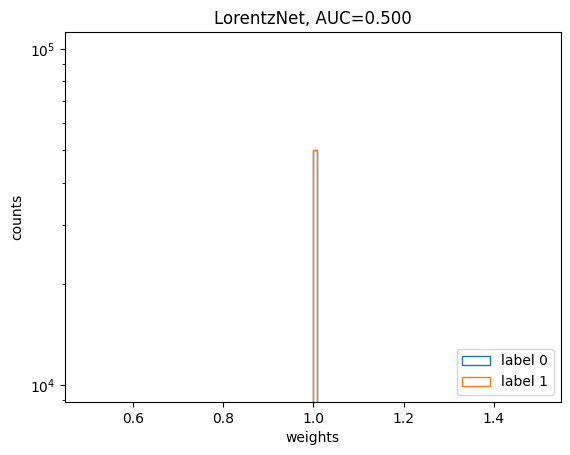

In [12]:
s = 'valid'

tests_truth_ln = [
{'exp_name': f'trial_{i+1}_ln_truth',
 'model_score': 'best_model_score'}
 for i  in range(5)]

tests_truth_pf = [
{'exp_name': f'trial_{i+1}_pn_truth',
    'model_score': 'best_model_score'}
    for i  in range(5)]

for i,test in enumerate(tests_truth_pf):
    exp_name = test['exp_name']
    jet_test = 'truth'

    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{jet_test}_{s}')['labels'].values
   # score = np.load(f'output/{exp_name}/best_model_score.npy')[:,0]
    #score = np.load(f'output/{exp_name}/best_model_val_auc.npy')[:,0]
    score = np.load(f'output/{exp_name}/best_model_val_loss.npy')[:,0]
    #score = np.load(f'output/{exp_name}/best_model_val_auc.npy')[:,0]
    weights = score/(1-score)
    assert len(score) == len(label)
    auc = roc_auc_score(label, score)
   # tpr, fpr, _ = roc_curve(label, score[:,0])
    plt.hist(weights[label==0], label='truth (label=0)',bins=np.arange(0.95,1.6,0.0005), histtype='step')
    plt.hist(weights[label==1], label='truth (label =1)',bins=np.arange(0.95,1.6,0.0005), histtype='step')

    plt.xlabel('weights')
    plt.ylabel('counts')
    plt.title(f'ParticleNet, AUC={auc:.3f}')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.show()

for i,test in enumerate(tests_truth_ln):
    exp_name = test['exp_name']
    jet_test = 'truth'

    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{jet_test}_{s}')['labels'].values
    #score = np.load(f'output/{exp_name}/best_model_score.npy')
    score = np.load(f'output/{exp_name}/score_39.npy')[:,2]
    weights = score/(1-score)
    assert len(score) == len(label)
    auc = roc_auc_score(label, score)
    #weights = np.log(weights+10**(-100))
   # tpr, fpr, _ = roc_curve(label, score[:,0])
    plt.hist(weights[label==0], label='label 0',bins=100, histtype='step')
    plt.hist(weights[label==1], label='label 1',bins=100, histtype='step')

    plt.xlabel('weights')
    plt.ylabel('counts')
    plt.title(f'LorentzNet, AUC={auc:.3f}')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.show()